In [3]:
from congestion_games import *
import matplotlib.pyplot as plt
import itertools
import numpy as np
import copy
import statistics
import seaborn as sns; sns.set()
from time import process_time
from tqdm import tqdm

myp_start = process_time()

def projection_simplex_sort(v, z=1):
	# Courtesy: EdwardRaff/projection_simplex.py
    if v.sum() == z and np.alltrue(v >= 0):
        return v
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

# Define the states and some necessary info
N = 8 #number of agents
harm = - 100 * N # pentalty for being in bad state

safe_state = CongGame(N,1,[[1,0],[2,0],[4,0],[6,0]])
bad_state = CongGame(N,1,[[1,-100],[2,-100],[4,-100],[6,-100]])
state_dic = {0: safe_state, 1: bad_state}

M = safe_state.num_actions 
D = safe_state.m #number facilities
S = 2

# Dictionary to store the action profiles and rewards to
selected_profiles = {}

# Dictionary associating each action (value) to an integer (key)
act_dic = {}
counter = 0
for act in safe_state.actions:
	act_dic[counter] = act 
	counter += 1

def get_next_state(state, actions):
    acts_from_ints = [act_dic[i] for i in actions]
    density = state_dic[state].get_counts(acts_from_ints)
    max_density = max(density)

    if state == 0 and max_density > N/2 or state == 1 and max_density > N/4:
      # if state == 0 and max_density > N/2 and np.random.uniform() > 0.2 or state == 1 and max_density > N/4 and np.random.uniform() > 0.1:
        return 1
    return 0

def pick_action(prob_dist):
    # np.random.choice(range(len(prob_dist)), 1, p = prob_dist)[0]
    acts = [i for i in range(len(prob_dist))]
    action = np.random.choice(acts, 1, p = prob_dist)
    return action[0]

def visit_dist(state, policy, gamma, T,samples):
    # This is the unnormalized visitation distribution. Since we take finite trajectories, the normalization constant is (1-gamma**T)/(1-gamma).
    visit_states = {st: np.zeros(T) for st in range(S)}        
    for i in range(samples):
        curr_state = state
        for t in range(T):
            visit_states[curr_state][t] += 1
            actions = [pick_action(policy[curr_state, i]) for i in range(N)]
            curr_state = get_next_state(curr_state, actions)
    dist = [np.dot(v/samples,gamma**np.arange(T)) for (k,v) in visit_states.items()]
    return dist 

def value_function(policy, gamma, T,samples):
    value_fun = {(s,i):0 for s in range(S) for i in range(N)}
    for k in range(samples):
        for state in range(S):
            curr_state = state
            for t in range(T):
                actions = [pick_action(policy[curr_state, i]) for i in range(N)]
                q = tuple(actions+[curr_state])
                rewards = selected_profiles.setdefault(q,get_reward(state_dic[curr_state], [act_dic[i] for i in actions]))                  
                for i in range(N):
                    value_fun[state,i] += (gamma**t)*rewards[i]
                curr_state = get_next_state(curr_state, actions)
    value_fun.update((x,v/samples) for (x,v) in value_fun.items())
    return value_fun

def Q_function(agent, state, action, policy, gamma, value_fun, samples):
    tot_reward = 0
    for i in range(samples):
        actions = [pick_action(policy[state, i]) for i in range(N)]
        actions[agent] = action
        q = tuple(actions+[state])
        rewards = selected_profiles.setdefault(q,get_reward(state_dic[state], [act_dic[i] for i in actions]))
        tot_reward += rewards[agent] + gamma*value_fun[get_next_state(state, actions), agent]
    return (tot_reward / samples)

def policy_accuracy(policy_pi, policy_star):
    total_dif = N * [0]
    for agent in range(N):
        for state in range(S):
            total_dif[agent] += np.sum(np.abs((policy_pi[state, agent] - policy_star[state, agent])))
	  # total_dif[agent] += np.sqrt(np.sum((policy_pi[state, agent] - policy_star[state, agent])**2))
    return np.sum(total_dif) / N

In [34]:
def Natural_PG(policy, gradient):
    gradient -= np.mean(gradient)
    new_policy = policy*np.exp(gradient)
    new_policy/=np.sum(new_policy)
    return new_policy
    
def PG(policy, gradient):
    gradient -= np.mean(gradient)
    new_policy = policy+(gradient)
    # print(new_policy)
    new_policy = np.maximum(new_policy,0)
    # print(new_policy)
    new_policy/=np.sum(new_policy)
    return new_policy

In [29]:
def policy_gradient(mu, max_iters, gamma, eta, T, samples):

    policy = {(s,i): [1/M]*M for s in range(S) for i in range(N)}
    policy_hist = [copy.deepcopy(policy)]

    for t in tqdm(range(max_iters)):

        #print(t)

        b_dist = M * [0]
        for st in range(S):
            a_dist = visit_dist(st, policy, gamma, T, samples)

            b_dist[st] = np.dot(a_dist, mu)
            
        grads = np.zeros((N, S, M))
        value_fun = value_function(policy, gamma, T, samples)
	
        for agent in range(N):
            for st in range(S):
                for act in range(M):
                    grads[agent, st, act] = b_dist[st] * Q_function(agent, st, act, policy, gamma, value_fun, samples)

        for agent in range(N):
            for st in range(S):
                # policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * grads[agent,st]), z=1)
                # policy[st, agent] = Natural_PG(policy[st, agent], eta * grads[agent,st])
                policy[st, agent] = PG(policy[st, agent], eta * grads[agent,st])
        policy_hist.append(copy.deepcopy(policy))

        if policy_accuracy(policy_hist[t], policy_hist[t-1]) < 10e-16:
      # if policy_accuracy(policy_hist[t+1], policy_hist[t]) < 10e-16: (it makes a difference, not when t=0 but from t=1 onwards.)
            return policy_hist

    return policy_hist


def get_accuracies(policy_hist):
    fin = policy_hist[-1]
    accuracies = []
    for i in range(len(policy_hist)):
        this_acc = policy_accuracy(policy_hist[i], fin)
        accuracies.append(this_acc)
    return accuracies

In [30]:
def full_experiment(runs,iters,eta,T,samples):


    densities = np.zeros((S,M))

    raw_accuracies = []
    for k in (range(runs)):
        policy_hist = policy_gradient([0.5, 0.5],iters,0.99,eta,T,samples)
        raw_accuracies.append(get_accuracies(policy_hist))

        converged_policy = policy_hist[-1]
        for i in range(N):
            for s in range(S):
                densities[s] += converged_policy[s,i]

    densities = densities / runs

    #densities = densities / runs

    # max_length = 0
    # for j in range(runs):
    #     max_length = max(max_length, len(raw_accuracies[j]))

    # plot_accuracies = np.zeros((runs, max_length))

    # for j in range(runs):
    #     j_len = len(raw_accuracies[j])
    #     plot_accuracies[j][:j_len] = raw_accuracies[j]
    
    plot_accuracies = np.array(list(itertools.zip_longest(*raw_accuracies, fillvalue=np.nan))).T
    clrs = sns.color_palette("husl", 3)
    piters = list(range(plot_accuracies.shape[1]))

    fig2 = plt.figure(figsize=(6,4))
    for i in range(len(plot_accuracies)):
        plt.plot(piters, plot_accuracies[i])
    plt.grid(linewidth=0.6)
    plt.gca().set(xlabel='Iterations',ylabel='L1-accuracy', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N, runs,eta))
    plt.show()
    fig2.savefig('individual_runs_n{}.png'.format(N),bbox_inches='tight')
    #plt.close()
    
    plot_accuracies = np.nan_to_num(plot_accuracies)
    pmean = list(map(statistics.mean, zip(*plot_accuracies)))
    pstdv = list(map(statistics.stdev, zip(*plot_accuracies)))
    
    fig1 = plt.figure(figsize=(6,4))
    ax = sns.lineplot(piters, pmean, color = clrs[0],label= 'Mean L1-accuracy')
    ax.fill_between(piters, np.subtract(pmean,pstdv), np.add(pmean,pstdv), alpha=0.3, facecolor=clrs[0],label="1-standard deviation")
    ax.legend()
    plt.grid(linewidth=0.6)
    plt.gca().set(xlabel='Iterations',ylabel='L1-accuracy', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N, runs,eta))
    plt.show()
    fig1.savefig('avg_runs_n{}.png'.format(N),bbox_inches='tight')
    #plt.close()
    
    #print(densities)

    fig3, ax = plt.subplots()
    index = np.arange(D)
    bar_width = 0.35
    opacity = 1

    #print(len(index))
    #print(len(densities[0]))
    rects1 = plt.bar(index, densities[0], bar_width,
    alpha= .7 * opacity,
    color='b',
    label='Safe state')

    rects2 = plt.bar(index + bar_width, densities[1], bar_width,
    alpha= opacity,
    color='r',
    label='Distancing state')

    plt.gca().set(xlabel='Facility',ylabel='Average number of agents', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N,runs,eta))
    plt.xticks(index + bar_width/2, ('A', 'B', 'C', 'D'))
    plt.legend()
    fig3.savefig('facilities_n{}.png'.format(N),bbox_inches='tight')
   #plt.close()
    plt.show()

    return fig1, fig2, fig3

 70%|█████████████████████████████████████████████████▎                    | 176/250 [01:05<00:27,  2.69it/s]


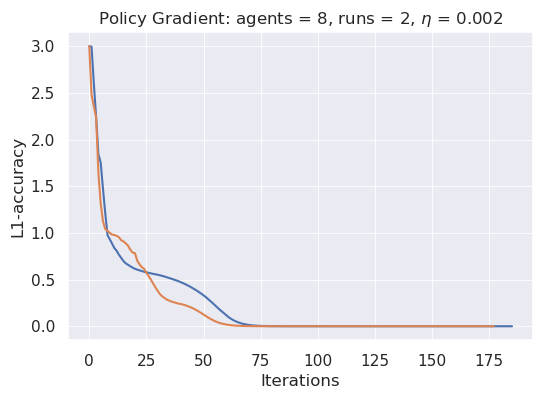

/home/youbang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


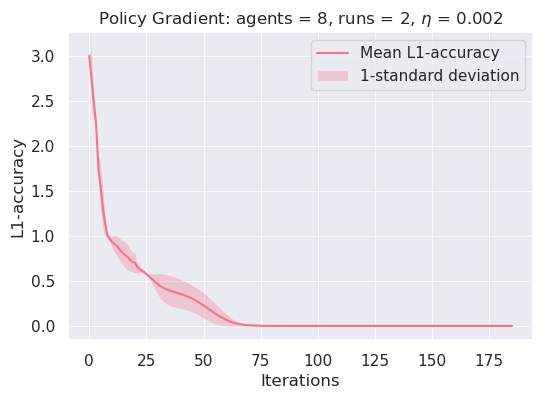

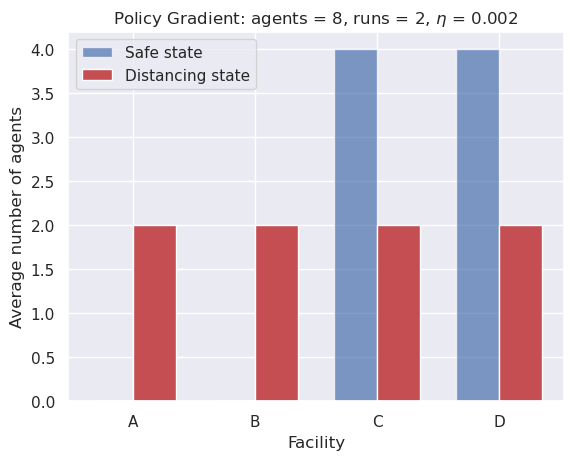

899.8593803


In [21]:
#full_experiment(10,1000,0.0001,20,10)
full_experiment(2,250,0.002,20,10)

myp_end = process_time()
elapsed_time = myp_end - myp_start
print(elapsed_time)

In [35]:
#full_experiment(10,1000,0.0001,20,10)
full_experiment(2,50,0.0001,20,10)

myp_end = process_time()
elapsed_time = myp_end - myp_start
print(elapsed_time)

  2%|█▍                                                                       | 1/50 [00:00<00:16,  3.03it/s]

[0.24449168 0.2466768  0.31574768 0.19308383]
[0.24449168 0.2466768  0.31574768 0.19308383]
[0.22817995 0.29470153 0.2349174  0.24220112]
[0.22817995 0.29470153 0.2349174  0.24220112]
[0.22873366 0.23110087 0.23838459 0.30178088]
[0.22873366 0.23110087 0.23838459 0.30178088]
[0.21422753 0.27716858 0.2216023  0.2870016 ]
[0.21422753 0.27716858 0.2216023  0.2870016 ]
[0.30478112 0.24749622 0.12964874 0.31807391]
[0.30478112 0.24749622 0.12964874 0.31807391]
[0.24426407 0.24717756 0.31265665 0.19590173]
[0.24426407 0.24717756 0.31265665 0.19590173]
[0.41646795 0.16811676 0.36195977 0.05345552]
[0.41646795 0.16811676 0.36195977 0.05345552]
[0.27529659 0.21505248 0.28458333 0.2250676 ]
[0.27529659 0.21505248 0.28458333 0.2250676 ]
[0.21339935 0.21658597 0.28300432 0.28701036]
[0.21339935 0.21658597 0.28300432 0.28701036]
[0.21387734 0.27792847 0.16020551 0.34798868]
[0.21387734 0.27792847 0.16020551 0.34798868]
[0.13743437 0.26189266 0.26790173 0.33277123]
[0.13743437 0.26189266 0.26790173 

  4%|██▉                                                                      | 2/50 [00:00<00:17,  2.82it/s]

[0.25348601 0.25885775 0.33339143 0.15426481]
[0.25348601 0.25885775 0.33339143 0.15426481]
[0.18902299 0.25754759 0.2678832  0.28554622]
[0.18902299 0.25754759 0.2678832  0.28554622]
[0.22215555 0.16444517 0.23918125 0.37421803]
[0.22215555 0.16444517 0.23918125 0.37421803]
[0.17731472 0.30716185 0.18997019 0.32555325]
[0.17731472 0.30716185 0.18997019 0.32555325]
[0.25189172 0.32295941 0.08404307 0.34110581]
[0.25189172 0.32295941 0.08404307 0.34110581]
[0.28520361 0.22612592 0.29870664 0.18996382]
[0.28520361 0.22612592 0.29870664 0.18996382]
[0.34914717 0.22815381 0.3639628  0.05873622]
[0.34914717 0.22815381 0.3639628  0.05873622]
[0.23851786 0.2422258  0.31667317 0.20258317]
[0.23851786 0.2422258  0.31667317 0.20258317]
[0.25501793 0.13411096 0.26931355 0.34155756]
[0.25501793 0.13411096 0.26931355 0.34155756]
[0.23898272 0.30576524 0.13145828 0.32379377]
[0.23898272 0.30576524 0.13145828 0.32379377]
[0.10078597 0.28875357 0.30131799 0.30914248]
[0.10078597 0.28875357 0.30131799 

  6%|████▍                                                                    | 3/50 [00:01<00:17,  2.72it/s]

[0.30744953 0.2358927  0.395276   0.06138176]
[0.30744953 0.2358927  0.395276   0.06138176]
[0.20240539 0.27493604 0.28763886 0.2350197 ]
[0.20240539 0.27493604 0.28763886 0.2350197 ]
[0.17533445 0.20075039 0.28131345 0.3426017 ]
[0.17533445 0.20075039 0.28131345 0.3426017 ]
[0.15168491 0.28535599 0.25174589 0.31121321]
[0.15168491 0.28535599 0.25174589 0.31121321]
[0.26642723 0.25841216 0.10668172 0.36847888]
[0.26642723 0.25841216 0.10668172 0.36847888]
[0.23821918 0.18214603 0.34009172 0.23954308]
[0.23821918 0.18214603 0.34009172 0.23954308]
[ 0.34327467  0.30248176  0.36500983 -0.01076626]
[0.34327467 0.30248176 0.36500983 0.        ]
[0.21377885 0.22040028 0.29903579 0.26678509]
[0.21377885 0.22040028 0.29903579 0.26678509]
[0.35236784 0.0692003  0.37385613 0.20457574]
[0.35236784 0.0692003  0.37385613 0.20457574]
[0.25538443 0.24199266 0.15250336 0.35011955]
[0.25538443 0.24199266 0.15250336 0.35011955]
[0.05612751 0.32521783 0.26339697 0.35525768]
[0.05612751 0.32521783 0.26339

  8%|█████▊                                                                   | 4/50 [00:01<00:17,  2.67it/s]

[ 0.34625088  0.21846729  0.4406327  -0.00535087]
[0.34625088 0.21846729 0.4406327  0.        ]
[0.18136088 0.2561677  0.27542586 0.28704556]
[0.18136088 0.2561677  0.27542586 0.28704556]
[0.15472448 0.24364264 0.33057895 0.27105394]
[0.15472448 0.24364264 0.33057895 0.27105394]
[0.09893688 0.29729379 0.33064566 0.27312367]
[0.09893688 0.29729379 0.33064566 0.27312367]
[0.21860364 0.2112259  0.1825334  0.38763706]
[0.21860364 0.2112259  0.1825334  0.38763706]
[0.32082394 0.15054436 0.31085726 0.21777444]
[0.32082394 0.15054436 0.31085726 0.21777444]
[ 0.30392648  0.32634773  0.39403675 -0.02431096]
[0.30392648 0.32634773 0.39403675 0.        ]
[0.20608541 0.21598453 0.29862608 0.27930398]
[0.20608541 0.21598453 0.29862608 0.27930398]
[0.331893   0.11095877 0.30389449 0.25325375]
[0.331893   0.11095877 0.30389449 0.25325375]
[0.24841937 0.23794109 0.1533683  0.36027124]
[0.24841937 0.23794109 0.1533683  0.36027124]
[0.05127928 0.32282786 0.26683398 0.35905888]
[0.05127928 0.32282786 0.2

 10%|███████▎                                                                 | 5/50 [00:01<00:17,  2.59it/s]

[ 0.37437172  0.24845185  0.40472742 -0.02755099]
[0.37437172 0.24845185 0.40472742 0.        ]
[0.22902648 0.23384521 0.25838407 0.27874424]
[0.22902648 0.23384521 0.25838407 0.27874424]
[0.18594721 0.20276897 0.29626063 0.31502318]
[0.18594721 0.20276897 0.29626063 0.31502318]
[0.0558781  0.33033745 0.36897002 0.24481443]
[0.0558781  0.33033745 0.36897002 0.24481443]
[0.27059322 0.19080045 0.23907531 0.29953102]
[0.27059322 0.19080045 0.23907531 0.29953102]
[0.31511077 0.14819991 0.31251886 0.22417046]
[0.31511077 0.14819991 0.31251886 0.22417046]
[0.30868337 0.33321282 0.33220342 0.02590039]
[0.30868337 0.33321282 0.33220342 0.02590039]
[0.21605266 0.22932049 0.24596271 0.30866414]
[0.21605266 0.22932049 0.24596271 0.30866414]
[0.36181055 0.14442714 0.19993857 0.29382375]
[0.36181055 0.14442714 0.19993857 0.29382375]
[0.20698443 0.19768975 0.19320993 0.40211589]
[0.20698443 0.19768975 0.19320993 0.40211589]
[-0.0286518   0.3928804   0.19773744  0.43803397]
[0.         0.3928804  0.1

 12%|████████▊                                                                | 6/50 [00:02<00:17,  2.53it/s]

[ 0.43810303  0.23730624  0.39540078 -0.07081006]
[0.43810303 0.23730624 0.39540078 0.        ]
[0.20313547 0.29130591 0.23859318 0.26696544]
[0.20313547 0.29130591 0.23859318 0.26696544]
[0.03656364 0.30242192 0.40010172 0.26091272]
[0.03656364 0.30242192 0.40010172 0.26091272]
[0.00903821 0.28504534 0.49182668 0.21408977]
[0.00903821 0.28504534 0.49182668 0.21408977]
[0.24563363 0.1686633  0.21930537 0.3663977 ]
[0.24563363 0.1686633  0.21930537 0.3663977 ]
[0.30978455 0.1452409  0.3133838  0.23159075]
[0.30978455 0.1452409  0.3133838  0.23159075]
[0.34380488 0.3706105  0.21281773 0.0727669 ]
[0.34380488 0.3706105  0.21281773 0.0727669 ]
[0.14845014 0.24493513 0.34916473 0.25745   ]
[0.14845014 0.24493513 0.34916473 0.25745   ]
[0.15281228 0.26317971 0.24023595 0.34377207]
[0.15281228 0.26317971 0.24023595 0.34377207]
[0.26163767 0.17370572 0.17541707 0.38923954]
[0.26163767 0.17370572 0.17541707 0.38923954]
[-0.02578899  0.35760496  0.17427072  0.49391332]
[0.         0.35760496 0.1

 14%|██████████▏                                                              | 7/50 [00:02<00:16,  2.58it/s]

[ 0.47028114  0.21906446  0.37143901 -0.06078461]
[0.47028114 0.21906446 0.37143901 0.        ]
[0.16286461 0.38826429 0.20851954 0.24035156]
[0.16286461 0.38826429 0.20851954 0.24035156]
[0.03162437 0.30030509 0.40126257 0.26680798]
[0.03162437 0.30030509 0.40126257 0.26680798]
[-0.01503981  0.26369873  0.47721751  0.27412358]
[0.         0.26369873 0.47721751 0.27412358]
[0.25790045 0.18311524 0.16775538 0.39122893]
[0.25790045 0.18311524 0.16775538 0.39122893]
[0.28677424 0.12350524 0.29838559 0.29133493]
[0.28677424 0.12350524 0.29838559 0.29133493]
[0.32037848 0.3499155  0.26361296 0.06609307]
[0.32037848 0.3499155  0.26361296 0.06609307]
[0.12513756 0.22426289 0.40107528 0.24952428]
[0.12513756 0.22426289 0.40107528 0.24952428]
[0.05980876 0.31233542 0.29394399 0.33391183]
[0.05980876 0.31233542 0.29394399 0.33391183]
[0.29123669 0.13609461 0.21284609 0.35982261]
[0.29123669 0.13609461 0.21284609 0.35982261]
[-0.07550128  0.34611076  0.24275036  0.48664015]
[0.         0.34611076

 16%|███████████▋                                                             | 8/50 [00:03<00:16,  2.59it/s]

[ 0.47931067  0.24585782  0.28123978 -0.00640827]
[0.47931067 0.24585782 0.28123978 0.        ]
[0.15587679 0.38337054 0.21072742 0.25002526]
[0.15587679 0.38337054 0.21072742 0.25002526]
[-0.06086235  0.32652097  0.43203077  0.30231061]
[0.         0.32652097 0.43203077 0.30231061]
[-0.00452956  0.25699183  0.46971412  0.27782361]
[0.         0.25699183 0.46971412 0.27782361]
[0.29394838 0.22071096 0.09908677 0.38625389]
[0.29394838 0.22071096 0.09908677 0.38625389]
[0.26543358 0.10544226 0.28505702 0.34406714]
[0.26543358 0.10544226 0.28505702 0.34406714]
[0.24481754 0.33316447 0.30703755 0.11498045]
[0.24481754 0.33316447 0.30703755 0.11498045]
[0.16164261 0.20578198 0.39024228 0.24233314]
[0.16164261 0.20578198 0.39024228 0.24233314]
[0.09798616 0.2922045  0.28164308 0.32816626]
[0.09798616 0.2922045  0.28164308 0.32816626]
[0.25368349 0.10136385 0.18831254 0.45664012]
[0.25368349 0.10136385 0.18831254 0.45664012]
[-0.02069764  0.30284568  0.21347873  0.50437322]
[0.         0.3028

 18%|█████████████▏                                                           | 9/50 [00:03<00:15,  2.57it/s]

[0.47127388 0.2414016  0.28074641 0.00657811]
[0.47127388 0.2414016  0.28074641 0.00657811]
[0.10691032 0.50368437 0.17177606 0.21762925]
[0.10691032 0.50368437 0.17177606 0.21762925]
[0.03746018 0.26304435 0.45089623 0.24859924]
[0.03746018 0.26304435 0.45089623 0.24859924]
[-0.0058725   0.2505068   0.47119245  0.28417325]
[0.         0.2505068  0.47119245 0.28417325]
[0.26709873 0.19741213 0.0794298  0.45605934]
[0.26709873 0.19741213 0.0794298  0.45605934]
[0.23671748 0.16445869 0.26681127 0.33201255]
[0.23671748 0.16445869 0.26681127 0.33201255]
[0.23846704 0.41254831 0.30933647 0.03964818]
[0.23846704 0.41254831 0.30933647 0.03964818]
[0.15526935 0.20159384 0.39169902 0.25143779]
[0.15526935 0.20159384 0.39169902 0.25143779]
[0.13465871 0.33160845 0.07151263 0.4622202 ]
[0.13465871 0.33160845 0.07151263 0.4622202 ]
[0.22503619 0.16163061 0.16886094 0.44447225]
[0.22503619 0.16163061 0.16886094 0.44447225]
[-0.02674678  0.35873563  0.18850316  0.47950798]
[0.         0.35873563 0.1

 20%|██████████████▍                                                         | 10/50 [00:03<00:15,  2.60it/s]

[ 0.52345556  0.21945538  0.33930135 -0.08221229]
[0.52345556 0.21945538 0.33930135 0.        ]
[0.11947874 0.51898419 0.19472379 0.16681327]
[0.11947874 0.51898419 0.19472379 0.16681327]
[0.10899596 0.105246   0.52871423 0.25704381]
[0.10899596 0.105246   0.52871423 0.25704381]
[-0.00610012  0.24512928  0.46871467  0.29225617]
[0.         0.24512928 0.46871467 0.29225617]
[ 0.35924003  0.29292215 -0.05466662  0.40250444]
[0.35924003 0.29292215 0.         0.40250444]
[0.20989018 0.14090906 0.32671666 0.32248409]
[0.20989018 0.14090906 0.32671666 0.32248409]
[ 0.30637874  0.33484911  0.38444085 -0.0256687 ]
[0.30637874 0.33484911 0.38444085 0.        ]
[0.13022812 0.25432009 0.37485197 0.24059981]
[0.13022812 0.25432009 0.37485197 0.24059981]
[0.20604332 0.32844458 0.07217272 0.39333938]
[0.20604332 0.32844458 0.07217272 0.39333938]
[0.17881664 0.1959686  0.13165499 0.49355977]
[0.17881664 0.1959686  0.13165499 0.49355977]
[0.05265531 0.32771135 0.16573739 0.45389595]
[0.05265531 0.3277

 22%|███████████████▊                                                        | 11/50 [00:04<00:15,  2.52it/s]

[ 0.44866212  0.24884267  0.36304408 -0.06054887]
[0.44866212 0.24884267 0.36304408 0.        ]
[0.11235435 0.51395387 0.19624882 0.17744295]
[0.11235435 0.51395387 0.19624882 0.17744295]
[0.12225427 0.12123571 0.54925626 0.20725375]
[0.12225427 0.12123571 0.54925626 0.20725375]
[0.0127348  0.25865399 0.44662817 0.28198305]
[0.0127348  0.25865399 0.44662817 0.28198305]
[0.32620761 0.30495062 0.03267432 0.33616745]
[0.32620761 0.30495062 0.03267432 0.33616745]
[0.18473099 0.1961743  0.30893225 0.31016246]
[0.18473099 0.1961743  0.30893225 0.31016246]
[0.24667201 0.31464091 0.40138165 0.03730543]
[0.24667201 0.31464091 0.40138165 0.03730543]
[0.10582065 0.2320067  0.35964021 0.30253244]
[0.10582065 0.2320067  0.35964021 0.30253244]
[0.12671034 0.32528072 0.11096289 0.43704606]
[0.12671034 0.32528072 0.11096289 0.43704606]
[0.16316124 0.1842282  0.16132235 0.49128821]
[0.16316124 0.1842282  0.16132235 0.49128821]
[0.03835862 0.27680438 0.19952282 0.48531417]
[0.03835862 0.27680438 0.19952

 24%|█████████████████▎                                                      | 12/50 [00:04<00:15,  2.51it/s]

[0.41696974 0.16488778 0.41174646 0.00639602]
[0.41696974 0.16488778 0.41174646 0.00639602]
[0.10504787 0.50892355 0.2017799  0.18424868]
[0.10504787 0.50892355 0.2017799  0.18424868]
[0.13455809 0.13636197 0.49941622 0.22966372]
[0.13455809 0.13636197 0.49941622 0.22966372]
[0.00627049 0.25492108 0.44908642 0.289722  ]
[0.00627049 0.25492108 0.44908642 0.289722  ]
[0.35440982 0.26723404 0.00205937 0.37629676]
[0.35440982 0.26723404 0.00205937 0.37629676]
[0.17815288 0.19296491 0.31136774 0.31751447]
[0.17815288 0.19296491 0.31136774 0.31751447]
[ 0.25664962  0.26212853  0.48404646 -0.00282461]
[0.25664962 0.26212853 0.48404646 0.        ]
[0.18063269 0.17965366 0.3776982  0.26201545]
[0.18063269 0.17965366 0.3776982  0.26201545]
[0.07109566 0.33805266 0.12974391 0.46110778]
[0.07109566 0.33805266 0.12974391 0.46110778]
[0.13989618 0.22962291 0.14752613 0.48295478]
[0.13989618 0.22962291 0.14752613 0.48295478]
[0.01526621 0.18756377 0.25459678 0.54257324]
[0.01526621 0.18756377 0.25459

 26%|██████████████████▋                                                     | 13/50 [00:05<00:14,  2.49it/s]

[0.38278917 0.13407594 0.4433322  0.03980269]
[0.38278917 0.13407594 0.4433322  0.03980269]
[0.1268461  0.53263376 0.17602114 0.16449899]
[0.1268461  0.53263376 0.17602114 0.16449899]
[0.14370774 0.08779021 0.5158496  0.25265245]
[0.14370774 0.08779021 0.5158496  0.25265245]
[-0.00067181  0.24989076  0.45152192  0.29925913]
[0.         0.24989076 0.45152192 0.29925913]
[ 0.40695019  0.32286999 -0.11103345  0.38121327]
[0.40695019 0.32286999 0.         0.38121327]
[0.24576307 0.20484811 0.26816128 0.28122754]
[0.24576307 0.20484811 0.26816128 0.28122754]
[0.24996318 0.31443298 0.42754622 0.00805762]
[0.24996318 0.31443298 0.42754622 0.00805762]
[0.14518875 0.20385336 0.34981111 0.30114678]
[0.14518875 0.20385336 0.34981111 0.30114678]
[0.0803576  0.34940868 0.08957573 0.48065798]
[0.0803576  0.34940868 0.08957573 0.48065798]
[0.16247164 0.25529396 0.12003415 0.46220025]
[0.16247164 0.25529396 0.12003415 0.46220025]
[0.0702348  0.18419504 0.19817145 0.54739871]
[0.0702348  0.18419504 0.1

 28%|████████████████████▏                                                   | 14/50 [00:05<00:14,  2.49it/s]

[0.47147186 0.09874876 0.41146479 0.01831459]
[0.47147186 0.09874876 0.41146479 0.01831459]
[0.11967619 0.52828629 0.17677227 0.17526525]
[0.11967619 0.52828629 0.17677227 0.17526525]
[0.16985681 0.11603335 0.42174238 0.29236745]
[0.16985681 0.11603335 0.42174238 0.29236745]
[0.08998736 0.21390023 0.42049463 0.27561778]
[0.08998736 0.21390023 0.42049463 0.27561778]
[ 0.45683164  0.3831572  -0.15716998  0.31718114]
[0.45683164 0.3831572  0.         0.31718114]
[0.33428816 0.16805603 0.23792454 0.25973127]
[0.33428816 0.16805603 0.23792454 0.25973127]
[ 0.33938249  0.40549113  0.39707211 -0.14194573]
[0.33938249 0.40549113 0.39707211 0.        ]
[0.23360655 0.16782541 0.3179713  0.28059674]
[0.23360655 0.16782541 0.3179713  0.28059674]
[0.00724286 0.41150679 0.02720448 0.55404586]
[0.00724286 0.41150679 0.02720448 0.55404586]
[0.15459612 0.25124239 0.12199165 0.47216984]
[0.15459612 0.25124239 0.12199165 0.47216984]
[-0.00309685  0.38306719 -0.13552794  0.7555576 ]
[0.         0.38306719

 30%|█████████████████████▌                                                  | 15/50 [00:05<00:14,  2.49it/s]

[ 0.50491106  0.13355367  0.52821632 -0.16668105]
[0.50491106 0.13355367 0.52821632 0.        ]
[0.09349913 0.58187073 0.15897149 0.16565865]
[0.09349913 0.58187073 0.15897149 0.16565865]
[0.14404066 0.17163064 0.40157111 0.28275759]
[0.14404066 0.17163064 0.40157111 0.28275759]
[0.06342008 0.27011208 0.40184839 0.26461945]
[0.06342008 0.27011208 0.40184839 0.26461945]
[0.46493615 0.40454604 0.07798263 0.05253518]
[0.46493615 0.40454604 0.07798263 0.05253518]
[0.30802092 0.14452018 0.29651394 0.25094497]
[0.30802092 0.14452018 0.29651394 0.25094497]
[ 0.34826336  0.40870389  0.40424486 -0.1612121 ]
[0.34826336 0.40870389 0.40424486 0.        ]
[0.14884855 0.31710631 0.31990604 0.2141391 ]
[0.14884855 0.31710631 0.31990604 0.2141391 ]
[0.08181389 0.32851396 0.02750039 0.56217176]
[0.08181389 0.32851396 0.02750039 0.56217176]
[0.14774487 0.24739567 0.12251517 0.48234429]
[0.14774487 0.24739567 0.12251517 0.48234429]
[-0.04591675  0.29196969  0.03999873  0.71394834]
[0.         0.29196969

 32%|███████████████████████                                                 | 16/50 [00:06<00:13,  2.52it/s]

[ 0.42565119  0.11089959  0.53832708 -0.07487786]
[0.42565119 0.11089959 0.53832708 0.        ]
[0.15048263 0.55680646 0.13809536 0.15461555]
[0.15048263 0.55680646 0.13809536 0.15461555]
[0.22641272 0.25591467 0.48895073 0.02872189]
[0.22641272 0.25591467 0.48895073 0.02872189]
[0.12222304 0.24383435 0.38340066 0.25054196]
[0.12222304 0.24383435 0.38340066 0.25054196]
[ 0.52116893  0.46351022  0.14168123 -0.12636038]
[0.52116893 0.46351022 0.14168123 0.        ]
[0.36511864 0.12129946 0.27820974 0.23537216]
[0.36511864 0.12129946 0.27820974 0.23537216]
[0.31506649 0.37048473 0.28354488 0.0309039 ]
[0.31506649 0.37048473 0.28354488 0.0309039 ]
[0.12040291 0.37713229 0.3008382  0.2016266 ]
[0.12040291 0.37713229 0.3008382  0.2016266 ]
[0.09917609 0.25767176 0.05332992 0.58982223]
[0.09917609 0.25767176 0.05332992 0.58982223]
[0.11870594 0.22236279 0.10294508 0.55598618]
[0.11870594 0.22236279 0.10294508 0.55598618]
[-0.02792283  0.16430246  0.10817215  0.75544821]
[0.         0.16430246

KeyboardInterrupt: 

 80%|████████████████████████████████████████████████████████              | 200/250 [01:13<00:18,  2.71it/s]


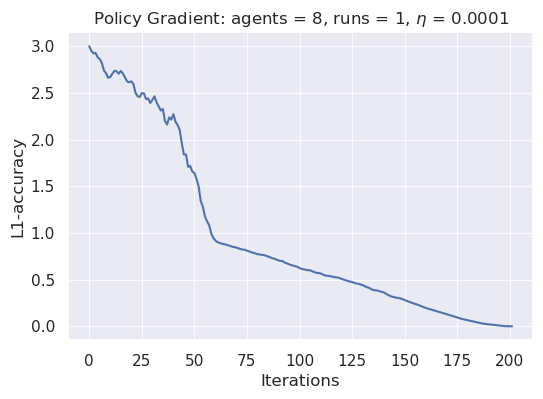

StatisticsError: variance requires at least two data points

In [8]:
#full_experiment(10,1000,0.0001,20,10)
full_experiment(2,250,0.0001,20,10)

myp_end = process_time()
elapsed_time = myp_end - myp_start
print(elapsed_time)